In [2]:
# Some packages you may need to install

#!pip install statsmodels==0.12.1
#!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn import linear_model
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [4]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)

<ipython-input-4-4608f95a2a7d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Insights Analysis

In [5]:
# Upload merged census, weather, and covid inference dataset
raw_merged_data_path = "data/clean/census_weather_covid_inference.csv"

raw_inference_data = pd.read_csv(raw_merged_data_path, index_col= "Unnamed: 0").drop(columns = ["NAME", "FIPS"])

Now that we have our merged inference and prediction datasets uploaded, we to clean them up for modeling including:

1. Checking for missing data
2. Removing features with too few data points
3. Imputing missing data
4. Transforming feature distributions
5. Scaling distributions



In [6]:
raw_inference_data.shape

(303, 11)

First we start with the inference dataset which has 303 records and 11 features. 

In [7]:
def countNaNs(df):
    """
    Returns a count of all NaNs for every column in the df.
    """
    nan_col_count = df.isna().sum()
    return nan_col_count

In [8]:
countNaNs(raw_inference_data)

income_med_dollars    0
insurance_perc        0
poverty_perc          0
pacific_perc          0
asian_perc            0
white_perc            0
black_perc            0
hispanic_perc         0
temp_mean             0
temp_std              0
Incident_Rate         0
dtype: int64

In [9]:
raw_inference_data.describe()

,income_med_dollars,insurance_perc,poverty_perc,pacific_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_std,Incident_Rate
count,303.000000,303.000000,303.000000,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,303.000000,303.000000,303.000000,303.000000
mean,64483.620462,90.764686,8.824092,-3.300330e+07,-3.300330e+07,-3.300323e+07,-3.300329e+07,16.609241,14.168747,8.040892,5868.221685
std,16268.546165,4.676796,4.020804,1.789407e+08,1.789407e+08,1.789407e+08,1.789407e+08,16.433967,5.190517,1.797021,2531.960693
min,30480.000000,68.600000,0.900000,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09,1.200000,-0.337500,1.617349,201.955929
25%,53848.500000,88.600000,6.100000,0.000000e+00,1.200000e+00,6.740000e+01,1.600000e+00,5.800000,9.996585,7.086731,4250.426068
50%,60733.000000,91.800000,8.200000,1.000000e-01,2.400000e+00,7.930000e+01,6.100000e+00,10.400000,14.324419,8.141998,5867.175069
75%,72813.500000,94.200000,11.000000,2.000000e-01,4.650000e+00,8.700000e+01,1.295000e+01,23.100000,17.906557,9.207249,7253.429863
max,151800.000000,98.300000,28.900000,1.170000e+01,4.390000e+01,9.590000e+01,5.830000e+01,90.000000,26.613934,13.103626,14267.040345


At first it appears the data has no missing values, but looking at the summary stats of the data, there is an abundance of -99999999 values.

This is a number used to denote missing values. Since all of these values are floats, we use use numpy's *isclose()* function to replace these values with NaN. 

In [10]:
def fillMissingWithNan(df):
    """
    Takes a dataframe and replaces all float values with -999999999 with NaN.
    """
    dfnan = df.mask(np.isclose(df.values,-999999999))
    return dfnan

In [11]:
nan_inference_data = fillMissingWithNan(raw_inference_data)

In [12]:
countNaNs(nan_inference_data)

income_med_dollars    0 
insurance_perc        0 
poverty_perc          0 
pacific_perc          10
asian_perc            10
white_perc            10
black_perc            10
hispanic_perc         0 
temp_mean             0 
temp_std              0 
Incident_Rate         0 
dtype: int64

In [13]:
nan_inference_data[nan_inference_data["pacific_perc"].isna()]

,income_med_dollars,insurance_perc,poverty_perc,pacific_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_std,Incident_Rate
7,53320,82.4,10.0,NaN,NaN,NaN,NaN,22.7,19.791257,7.248394,6329.931384
14,55727,94.0,9.7,NaN,NaN,NaN,NaN,1.8,11.998361,10.099168,9898.372431
39,80973,87.7,0.9,NaN,NaN,NaN,NaN,12.9,8.599258,9.746907,6285.722194
90,39063,86.2,20.5,NaN,NaN,NaN,NaN,3.0,19.410411,6.778858,6985.593548
134,43290,85.5,9.0,NaN,NaN,NaN,NaN,6.9,13.958470,7.589659,5667.134421
176,56276,88.9,5.8,NaN,NaN,NaN,NaN,17.1,7.422149,9.071974,9146.158982
180,55717,94.4,10.4,NaN,NaN,NaN,NaN,1.4,12.957923,8.932378,5790.050348
223,50049,77.7,11.0,NaN,NaN,NaN,NaN,28.6,20.601776,6.753067,4794.885456
255,46540,94.1,10.9,NaN,NaN,NaN,NaN,1.7,11.847479,8.242791,3639.535993
293,49715,86.8,12.3,NaN,NaN,NaN,NaN,2.7,17.919126,7.789175,8975.139286


There are 10 NaNs for all our our race columns (not including hispanic ehtnicity).

Since these 10 rows are all from the same record, they are not missing at random and imputation would be a poor method to try and utilize these records.

Instead we will remove them. 

In [14]:
remove_missing_inference = nan_inference_data[~nan_inference_data["pacific_perc"].isna()]
remove_missing_inference

,income_med_dollars,insurance_perc,poverty_perc,pacific_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_std,Incident_Rate
0,59049,94.1,9.8,0.1,3.0,71.3,22.4,5.9,15.382514,8.917145,6625.828000
1,82369,95.2,5.6,0.1,7.3,71.4,13.1,7.0,8.887978,11.746417,6815.458157
2,80096,94.7,2.7,0.3,6.3,83.4,6.2,5.2,7.541530,11.488897,5880.866494
3,59716,89.3,7.7,0.0,4.3,77.8,8.6,15.0,14.396175,9.938393,7639.494460
4,64871,96.3,6.6,0.0,3.9,79.4,12.9,2.3,11.866667,9.198555,4424.918486
...,...,...,...,...,...,...,...,...,...,...,...
298,51749,84.9,7.2,0.2,2.3,81.3,9.6,19.8,17.574863,8.689958,8144.899040
299,53793,80.2,13.4,0.0,1.3,74.1,18.4,19.2,18.798634,7.568277,5495.986123
300,55003,86.0,13.4,0.2,2.2,80.9,6.9,36.3,15.357377,9.507474,13484.282076
301,41123,70.0,22.6,0.0,0.7,93.7,0.9,90.0,24.348224,5.120266,6977.216817


In [15]:
countNaNs(remove_missing_inference)

income_med_dollars    0
insurance_perc        0
poverty_perc          0
pacific_perc          0
asian_perc            0
white_perc            0
black_perc            0
hispanic_perc         0
temp_mean             0
temp_std              0
Incident_Rate         0
dtype: int64

Now that we have handled missing values (none are left), we can look at the distribution of the data.

In [16]:
def plotAllDistributions(df, cols = False, save_fig = False):
    """
    Takes a dataframe, and plots the distribution of all columns.
    Optionally you can specify your columns of interest as an array.
    Returns either the figure, or saves it to a the Figures directory.
    """
    if cols:
        df = df.loc[:cols]

    fig = df.hist(layout = (4, -(-df.shape[1] // 4)), figsize = (20,20))
    
    if save_fig:
        figdir = os.path.join("Figures", save_fig)
        return plt.savefig(figdir)

    else:
        return fig


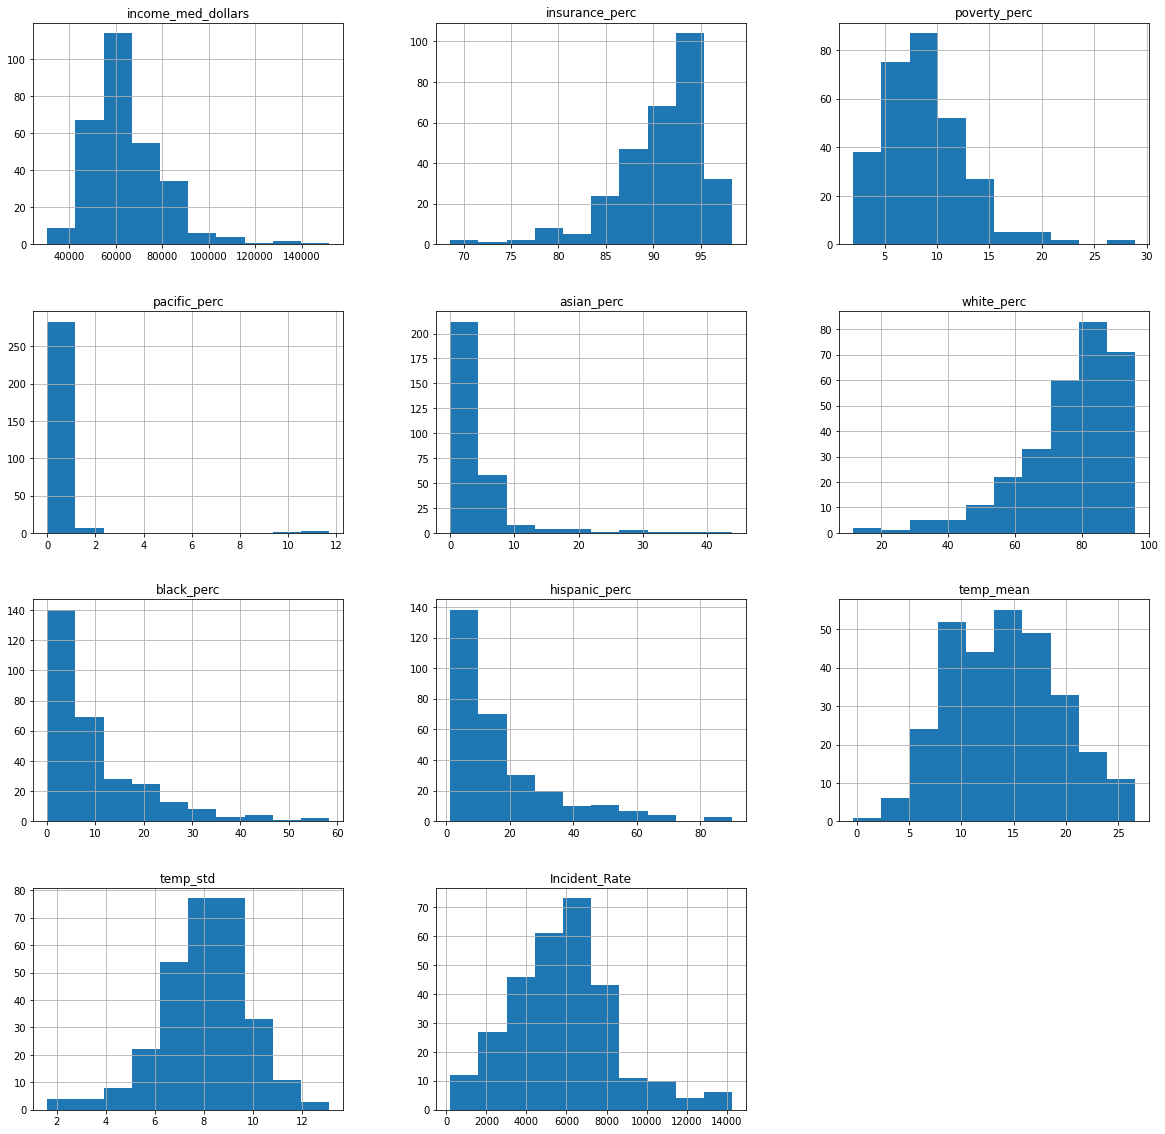

In [17]:
plotAllDistributions(remove_missing_inference);

Some of the features look normally distributed including:

1. Temperature mean
2. Temperature standard deviation

Most of the feature do not have normal distributions including:

1. Income
2. Percent insured
3. Percent in poverty
4. All race and ethnicity features



In [18]:
def inference_transform(df):
    transdf = df.copy()

    transdf["income_med_dollars"] = np.log10(transdf["income_med_dollars"]+1)
    transdf["insurance_perc"] = transdf["insurance_perc"]**2
    transdf["poverty_perc"] = transdf["poverty_perc"]**(1/3)
    transdf["white_perc"] = transdf["white_perc"]**3
    transdf["black_perc"] = np.log10(transdf["black_perc"]+1)
    transdf["asian_perc"] = np.log10(transdf["asian_perc"]+1)
    transdf["pacific_perc"] = np.log10(transdf["pacific_perc"]+1)
    transdf["hispanic_perc"] = np.log10(transdf["hispanic_perc"]+1)
    transdf["Incident_Rate"] = transdf["Incident_Rate"]#**(1/2)

    return transdf

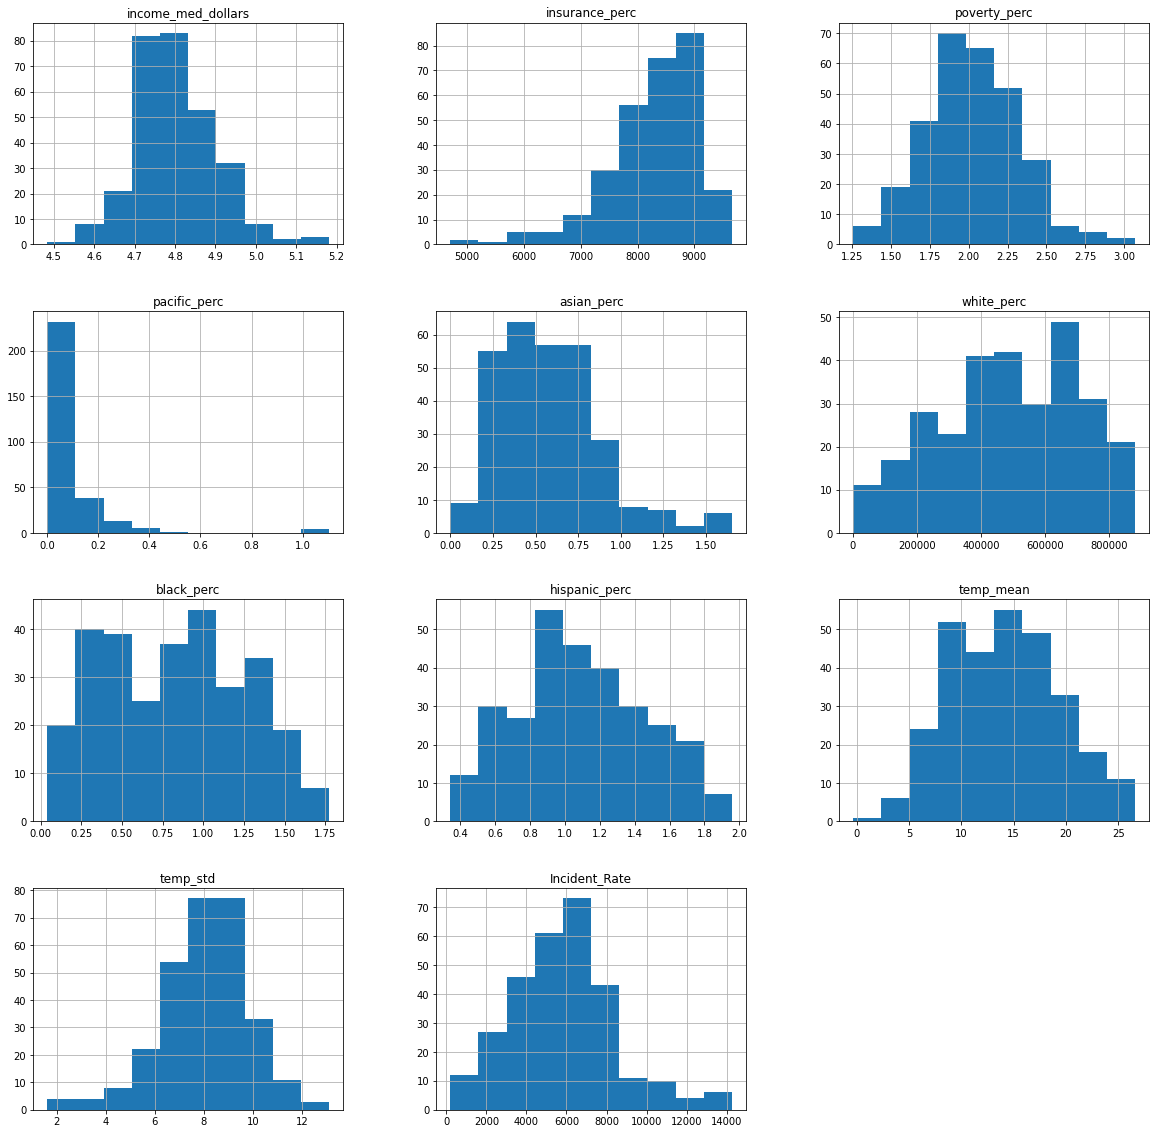

In [19]:
transformed_inference = inference_transform(remove_missing_inference)
plotAllDistributions(transformed_inference);

In [20]:
def normalTestAllFeatures(df, alpha = 0.05):
    """
    Takes a dataframe and performs the Shapiro-Wilk test of normality.
    Returns a dataframe summary including if the test is normal, and the p-value.
    
    A p-value <= alpha indicates that the feature rejects the null hypothesis that the data is normally distributed.
    """
    columns = df.columns.values
    normal = []
    p = []
    
    for i in columns:
        s, pval = stats.shapiro(transformed_inference[i])
        p.append(pval)
        if pval <= alpha:
            normal.append("No")
        else:
            normal.append("Yes")
    
    df_report = pd.DataFrame({"Feature" : columns,
                                "Normal" : normal,
                                "p-value" : p })
    return df_report

In [21]:
normalTestAllFeatures(transformed_inference)

,Feature,Normal,p-value
0,income_med_dollars,No,2.497866e-04
1,insurance_perc,No,8.343892e-12
2,poverty_perc,Yes,2.413526e-01
3,pacific_perc,No,1.502684e-28
4,asian_perc,No,3.293390e-08
5,white_perc,No,1.794088e-05
6,black_perc,No,5.272252e-06
7,hispanic_perc,No,1.032465e-03
8,temp_mean,No,3.586265e-02
9,temp_std,No,1.887427e-04


In [22]:
def pairplotsAllFeatures(df, title = "Pair Plots",path = "Figures", save_fig = False):
    fig = sns.pairplot(df, corner=True)
    fig.fig.suptitle(title)
    
    if save_fig:
        figdir = os.path.join(path, save_fig)
        return plt.savefig(dr)
    else:
        return fig

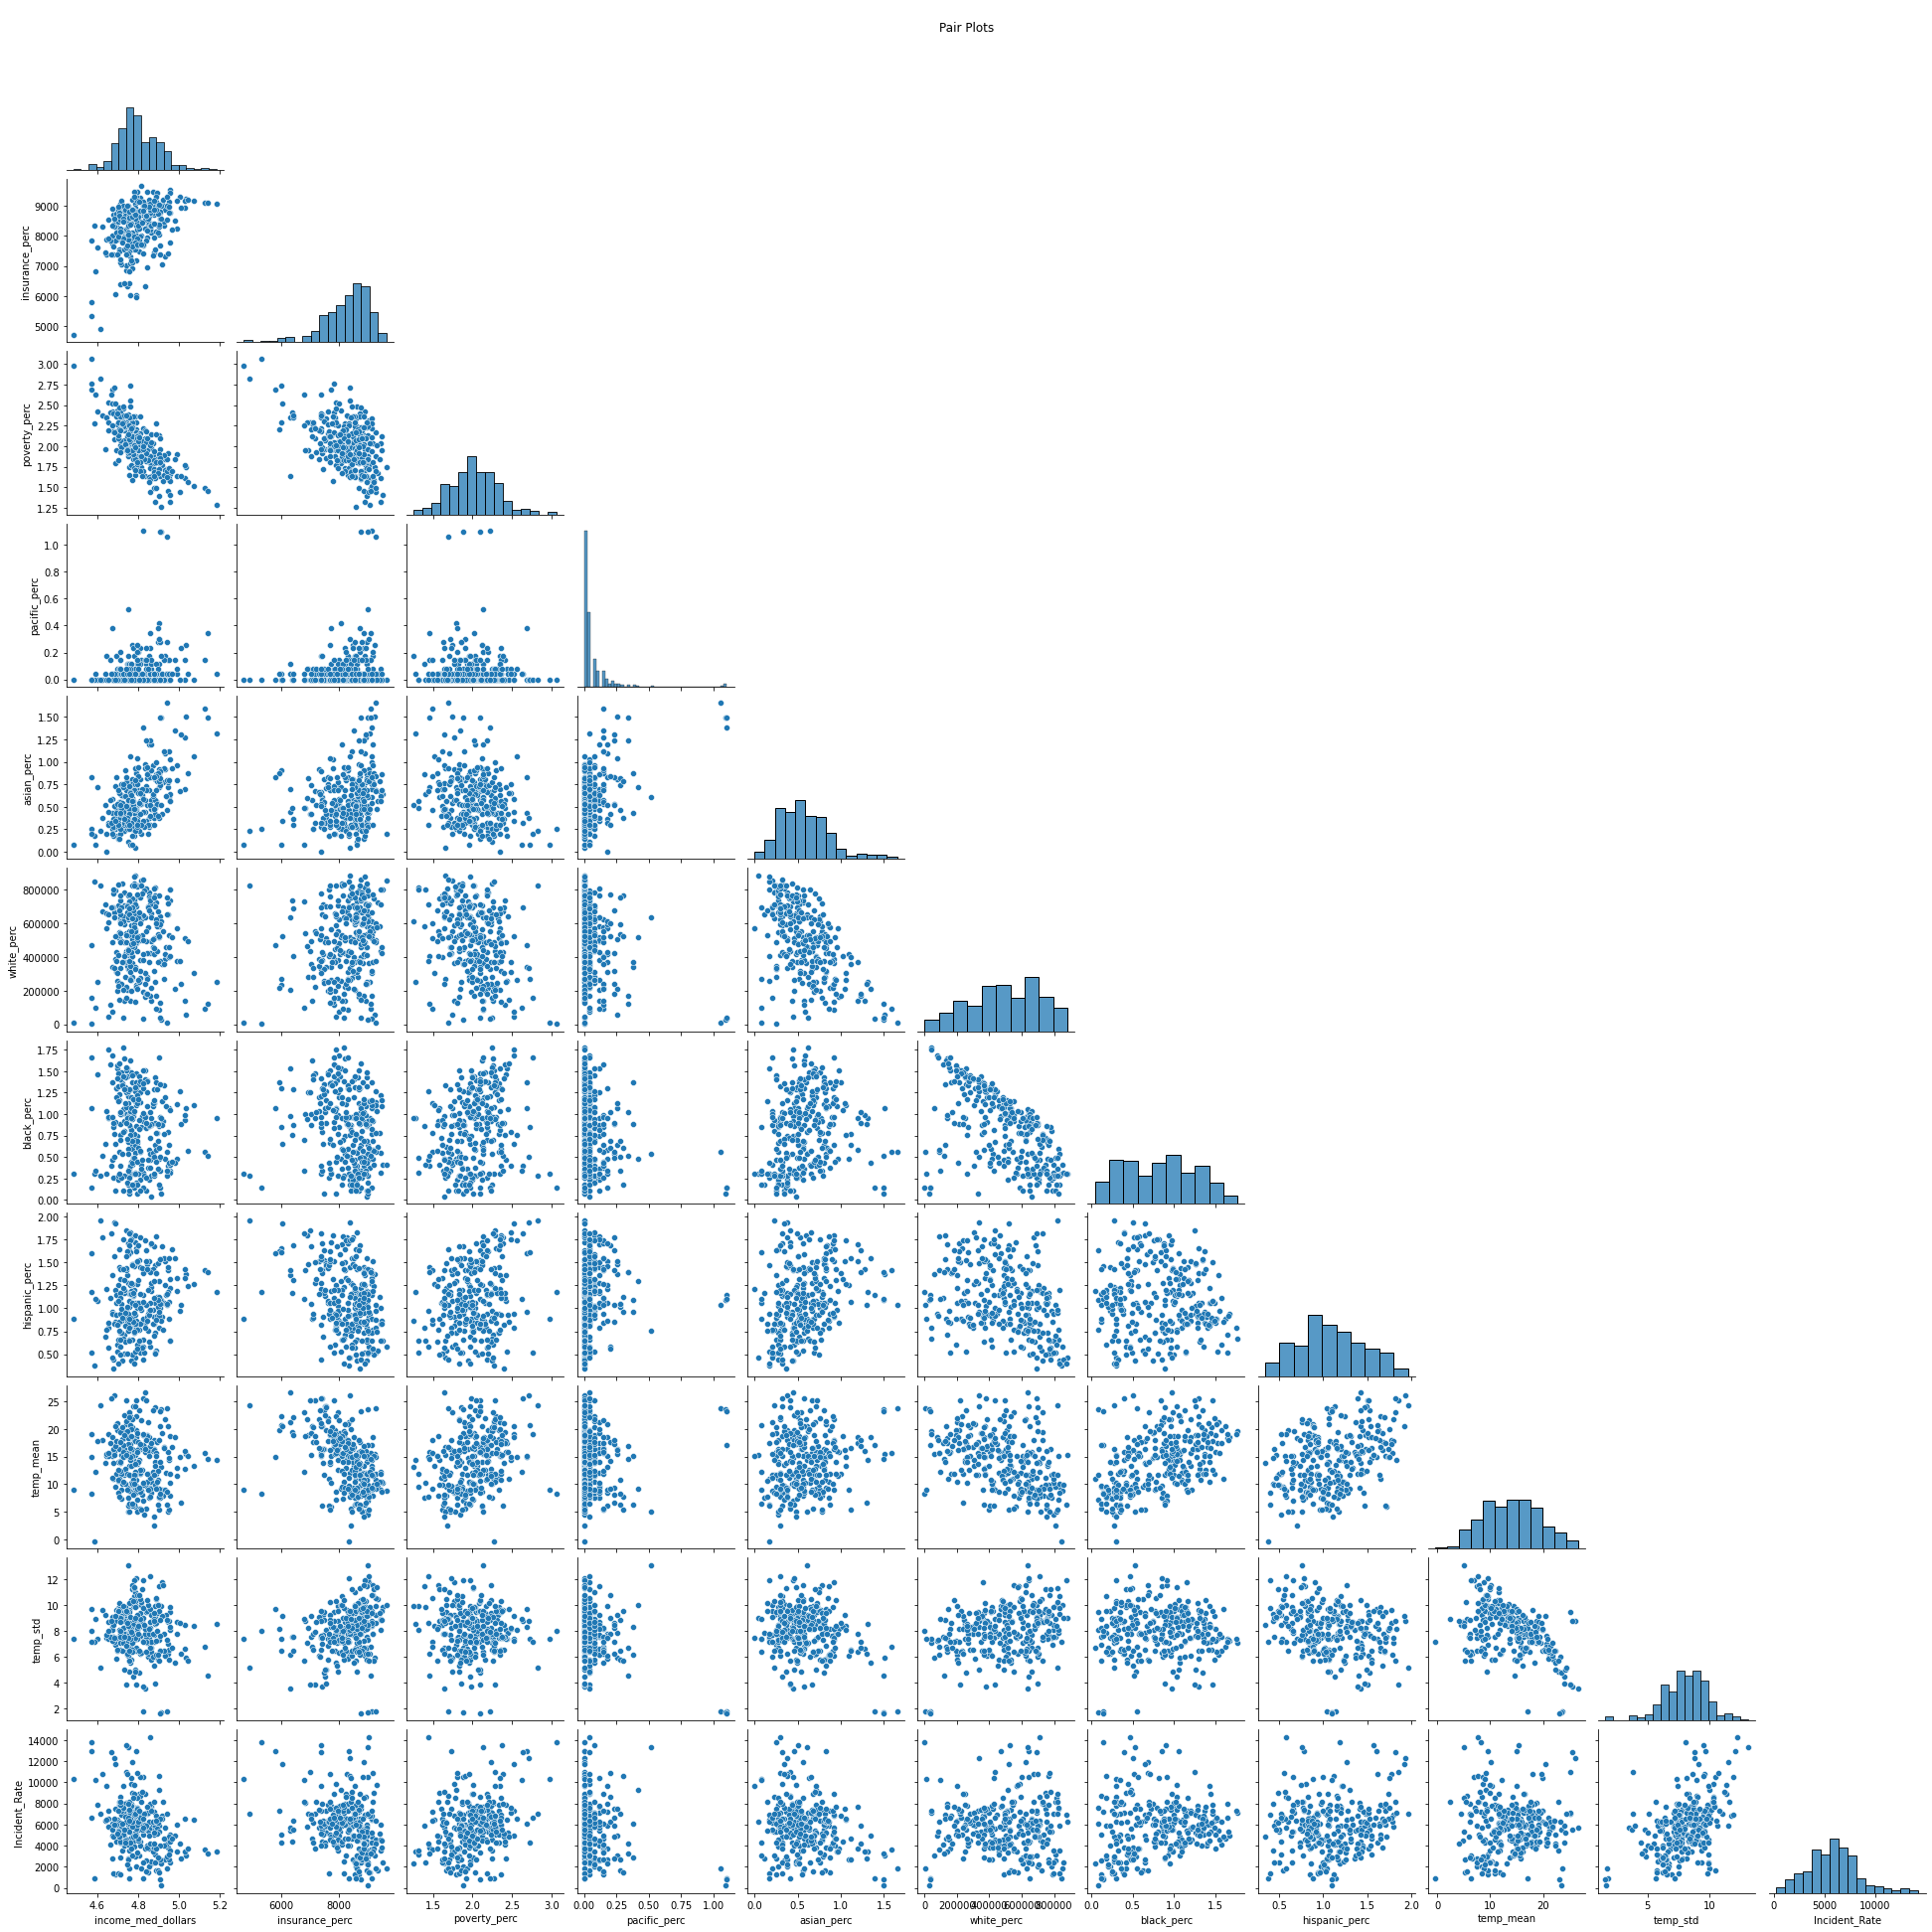

In [23]:
pairplotsAllFeatures(transformed_inference);

After transforming our features and testing for normality, we can see that:

1. Most features are still **not normal**
    - This is possibly OK, as long as the residuals of our model are normal independent/identically distributed with $u = 0$ and constant variance.
2. The **Percent Pacific** feature has too many 0 values to be of much use in our model
    - Remove this feature
3. There is some moderate multicolinearity in our dataset betwee:
    - temperature mean and temperature standard deviation
    - insured and income
    - poverty and income

In [24]:
remove_features_inference = transformed_inference.drop(columns= "pacific_perc")

Next, we want to normalize our data. This has the benefit of both intepretability of the coefficient, as well as a providing equally weighted scales during regularization.

In [25]:
def normalize_data(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [26]:
normalized_inference = normalize_data(remove_features_inference)
normalized_inference

,income_med_dollars,insurance_perc,poverty_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_std,Incident_Rate
0,0.411893,0.836980,0.486524,0.364389,0.409901,0.766791,0.307077,0.583272,0.635523,0.456725
1,0.619208,0.878988,0.285200,0.556260,0.411636,0.639747,0.346815,0.342300,0.881841,0.470207
2,0.601778,0.859833,0.073281,0.522515,0.657099,0.471189,0.278340,0.292342,0.859421,0.403759
3,0.418889,0.659386,0.395144,0.438358,0.533080,0.543338,0.533024,0.546675,0.724434,0.528794
4,0.470463,0.921484,0.340467,0.417732,0.566765,0.636165,0.108926,0.452821,0.660023,0.300244
...,...,...,...,...,...,...,...,...,...,...
298,0.329699,0.504758,0.370984,0.313824,0.608568,0.568190,0.603507,0.664616,0.615744,0.564728
299,0.353828,0.348216,0.616569,0.218931,0.460336,0.719776,0.595644,0.710023,0.518090,0.376395
300,0.367683,0.542683,0.616569,0.305735,0.599602,0.494458,0.760406,0.582339,0.686918,0.944347
301,0.186543,0.039145,0.866492,0.139476,0.932623,0.137071,1.000000,0.915934,0.304965,0.481708


## Models Used for Inference
Since the main objective of this first analysis is to understand the importance of temperature and demographic factors as a function of the proportion of the population infected with COVID-19, we can use linear regression models. 
Linear regression allows us to easily assess the direction and weight of each feature and is more intepretable than other algorithms. In addition, our dependent variable and features are all continuous quantitative variables which can be modeled effectively through linear combinations.
We will create three linear regression models:

**1. Ordinary Least Squares (OLS)** calculated by the normal equation $\hat{\theta} = (\mathbb{X}^T\mathbb{X})^{-1} \mathbb{X}^T\mathbb{Y}$

**2. Ridge Regression** optimized by L2 regularization of the ${\theta}$ coefficients such that $\hat{\theta}_\alpha = \arg \min_\theta \left(\frac{1}{n} \sum_{i=1}^n \left(Y_i -  f_\theta(X_i)\right)^2 \right) + \alpha \sum_{k=1}^d {\theta_k}^2$

**3. Least Absolute Shrinkage and Selection Operator (Lasso)** optimized by L1 regularization of the ${\theta}$ coefficients such that $\hat{\theta}_\alpha = \arg \min_\theta \left(\frac{1}{n} \sum_{i=1}^n \left(Y_i -  f_\theta(X_i)\right)^2 \right) + \alpha \sum_{k=1}^d |\theta_k|$

### Feature Importance
Feature importance will be evaluated in two ways.

1. **Through hypothesis testing of the p-value of t-tests for each coefficient in our model.**
    - For our hypothesis test, we will set $\alpha$ = 0.05
    - For any coefficients that have a value below $\alpha$, we will reject the $H_0$ that the coefficient = 0

2. **Through observing the effect of regularization**
    - Any features that have coefficients near 0 in the ridge regression, or eliminated in the lasso regression model can be interpreted as features of lower importance. 

### Causal Inference in Observational Studies
We should always approach modeling observational studies with caution. There are many assumptions and factors we cannot control in this analysis such as . 
It is typical that in observational studies there is a lower $R^2$ than might be expected from experimental studies due to the many factors that are not measured.

In [35]:
inference_X = normalized_inference.drop(columns= "Incident_Rate")
inference_Y = normalized_inference["Incident_Rate"]

In [59]:
def olsSummaryStats(x, y):
    """
    Takes a set of features and a response variable.
    Returns summary statistics of Ordinary Least Squares.

    x - Set of features in identity matrix.
    y - Response variable to predict
    """

    ols_sig_x = sm.add_constant(x)
    ols_sig_model = sm.OLS(y, ols_sig_x)
    ols_sig_test = ols_sig_model.fit()
    print(ols_sig_test.summary())
    return ols_sig_test

In [60]:
ols_inference = olsSummaryStats(x = inference_X, y = inference_Y)

                            OLS Regression Results                            
Dep. Variable:          Incident_Rate   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     29.99
Date:                Thu, 28 Jan 2021   Prob (F-statistic):           1.79e-36
Time:                        23:50:18   Log-Likelihood:                 183.76
No. Observations:                 293   AIC:                            -347.5
Df Residuals:                     283   BIC:                            -310.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1376      0

In [38]:
def ridgeRegression(x, y, alpha = 0.1):
    ridge = linear_model.Ridge(alpha = alpha)
    ridge.fit(x,y)
    return ridge

def ridgeCV(x, y):
    ridgeCV_model = linear_model.RidgeCV(cv=5)
    ridgeCV_model.fit(x,y)
    return ridgeCV_model

def lassoRegression(x,y, alpha = 0.1):
    lasso = linear_model.Lasso(alpha = alpha)
    lasso.fit(x,y)
    return lasso

def lassoCV(x,y):
    lassoCV_model = linear_model.LassoCV(cv = 5, random_state=1)
    lassoCV_model.fit(x,y)
    return lassoCV_model

def olsResidPlot(olsmodel):
    fig = plt.scatter(olsmodel.model.exog[:,1], olsmodel.resid)
    plt.axhline(y=0, color='black', linestyle='dotted')
    plt.title("Residual Plot for Ordinary Least Square")
    return fig

def residualPlot(xval, yval, model, t = "Residual Plot"):
    y_pred = model.predict(xval)
    fig = sns.residplot(x=y_pred, y=yval)
    plt.title(t)
    return fig

def mse(x, y, model):
    y_pred = model.predict(x)
    mse = 1/len(y)*sum((y-y_pred)**2)
    return mse 

In [46]:
def alpha_plot(x, y, alphas, reg, coeff = False, saveimg = False):
    """
    Takes an array of alpha values and plots either the mean squared error as a function of alpha (default)
    OR plots the coefficients as a function of alpha.
    
    Change coeff to True if you want to plot the coefficients.
    """
    coefs = []
    mses = []
    
    reg_low = reg.lower()
    
    if reg_low == "ridge":
        title1 = 'Ridge Regression'
        for a in alphas:
            ridge = ridgeRegression(x,y,a)
            coefs.append(ridge.coef_)
            mses.append(mse(x,y,ridge)) 
    elif reg_low == "lasso":
        title1 = 'Lasso Regression'
        for a in alphas:
            lasso = lassoRegression(x,y,a)
            coefs.append(lasso.coef_)
            mses.append(mse(x,y,lasso))   

        
    if coeff:
        title2 = " Coefficients as a function of alpha."
        full_title = title1+title2
        ax = plt.gca()
        ax.plot(alphas, coefs) #Find a way to label each coeff with col name, label = x.columns.values)
        plt.xlabel('Alpha')
        plt.ylabel('Normalized weights')
        plt.title(full_title)
    
    else:
        title2 = " MSE as a function of alpha."
        full_title = title1+title2
        ax = plt.plot(alphas, mses)
        plt.xlabel('Alpha')
        plt.ylabel('Mean Squared Error')
        plt.title(full_title)
    
    if saveimg:
        ititle = full_title.replace(" ", "_")
        return plt.savefig(os.path.join("Figures", ititle))
    else:
        return plt.show()

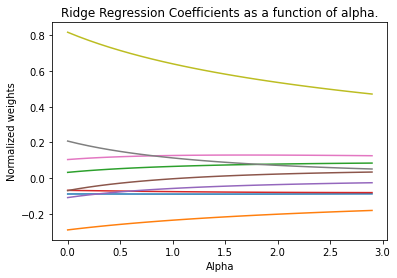

In [48]:
ridge_alpha_coef_fig = alpha_plot(inference_X, inference_Y,  alphas = np.arange(0,3, 0.1), reg="ridge", coeff = True, saveimg = True)

<ipython-input-38-1bb34cdab298>:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(x,y)
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.446923782423869, tolerance: 0.0009560703416868132
  model = cd_fast.enet_coordinate_descent(


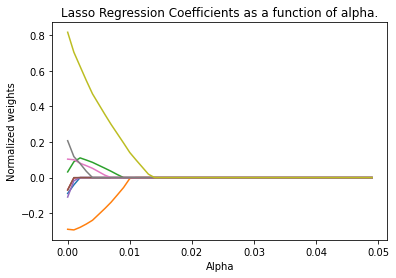

In [49]:
lasso_alpha_coef_fig = alpha_plot(inference_X, inference_Y, alphas = np.arange(0,0.05, 0.001), reg="lasso", coeff= True, saveimg = True)

In [50]:
ridge_inference = ridgeCV(inference_X, inference_Y)
lasso_inference = lassoCV(inference_X, inference_Y)

In [51]:
print(f"Ridge Regression alpha: {ridge_inference.alpha_}\nLasso Regression alpha: {lasso_inference.alpha_}")

Ridge Regression alpha: 1.0
Lasso Regression alpha: 0.00016614214207090236


In [54]:
ridge_inf_r2 = r2_score(inference_Y, ridge_inference.predict(inference_X))
lasso_inf_r2 = r2_score(inference_Y, lasso_inference.predict(inference_X))

ridge_inf_mse = mse(inference_X, inference_Y, ridge_inference)
lasso_inf_mse = mse(inference_X, inference_Y, lasso_inference)

In [55]:
## How do the model's coefficients stack up?

In [56]:
def modelTableInference(hm = False, title = "Heatmap of the Coefficients for All Models", saveimg = False):
    r2 = pd.DataFrame({"Rsquared" : 
                       [ols_inference.rsquared,
                        ridge_inf_r2,
                        lasso_inf_r2]})
    
    MSE = pd.DataFrame({"MSE" : 
                        [ols_inference.mse_resid,
                         ridge_inf_mse,
                         lasso_inf_mse]})
    
    intercept = pd.DataFrame({"Intercept" : 
                              [ols_inference.params[0],
                               ridge_inference.intercept_,
                               lasso_inference.intercept_]})
    
    coeff = pd.DataFrame({0: ols_inference.params[1:].values,
                          1: ridge_inference.coef_,
                          2: lasso_inference.coef_}).transpose()
    coeff.columns = inference_X.columns.values
    
    table = pd.concat([r2,MSE,intercept, coeff], axis = 1).rename({0: "OLS",
                                                                   1: "Ridge",
                                                                   2: "Lasso"}, axis = "index")
    if hm:
        fig = sns.heatmap(table.drop(columns=["Rsquared", "MSE", "Intercept"]),cmap="coolwarm");
        fig.set_title(title)
        if saveimg:
            return plt.savefig(os.path.join("Figures", title))
        else:
            return fig
    else:
        return table

In [61]:
modelTableInference()

,Rsquared,MSE,Intercept,income_med_dollars,insurance_perc,poverty_perc,asian_perc,white_perc,black_perc,hispanic_perc,temp_mean,temp_std
OLS,0.488129,0.017293,0.137555,-0.089193,-0.290486,0.031928,-0.068833,-0.109301,-0.070012,0.103800,0.207355,0.817177
Ridge,0.474072,0.017161,0.167622,-0.089539,-0.235979,0.065314,-0.075954,-0.058068,-0.003924,0.126559,0.112983,0.640274
Lasso,0.487681,0.016717,0.128645,-0.081506,-0.290647,0.041815,-0.056947,-0.089680,-0.051371,0.106284,0.187439,0.794637


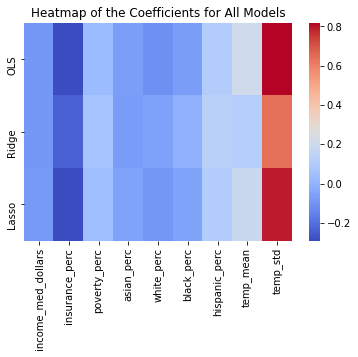

In [62]:
modelTableInference(hm= True, saveimg = True);

### Insights

Our regression analysis indicates that we have 4 significant features

1. Percent insured
2. Temperature mean
3. Temperature standard deviation

Of these, the feature with the most weight is the **temperature standard deviation**.

In [ ]:
## Do our models violate the assumptions of linear regression?
# Look at residuals

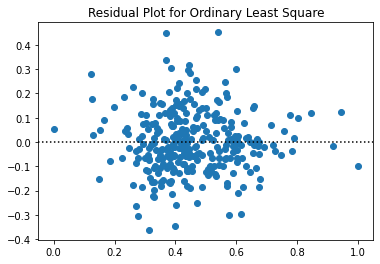

In [63]:
olsResidPlot(ols_inference);

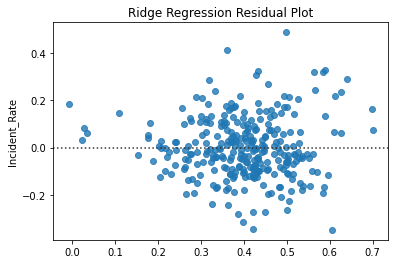

In [64]:
residualPlot(inference_X, inference_Y, ridge_inference, t = "Ridge Regression Residual Plot");

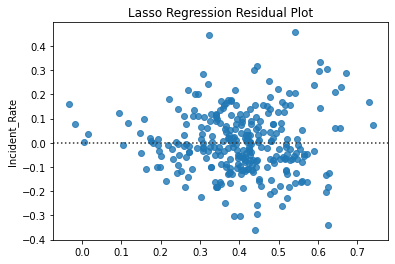

In [65]:
residualPlot(inference_X, inference_Y, lasso_inference, t = "Lasso Regression Residual Plot");

In [ ]:
# Our residual plots show there is still some heteroscedasticity violating the assumptions of linear regression. 
# Perhaps with a bit more cleanup, these values would be less clustered towards the center!

# Predictive Analytics

In [68]:
prediction_raw = pd.read_csv("data/clean/census_covid_prediction.csv", index_col= "Unnamed: 0").drop(columns  = "NAME")

In [69]:
nan_prediction = fillMissingWithNan(prediction_raw)
countNaNs(nan_prediction)

income_med_dollars    0
insurance_perc        0
poverty_perc          0
pacific_perc          0
asian_perc            0
white_perc            0
black_perc            0
hispanic_perc         0
FIPS                  0
Incident_Rate         0
dtype: int64

array([[<AxesSubplot:title={'center':'income_med_dollars'}>,
        <AxesSubplot:title={'center':'insurance_perc'}>,
        <AxesSubplot:title={'center':'poverty_perc'}>],
       [<AxesSubplot:title={'center':'pacific_perc'}>,
        <AxesSubplot:title={'center':'asian_perc'}>,
        <AxesSubplot:title={'center':'white_perc'}>],
       [<AxesSubplot:title={'center':'black_perc'}>,
        <AxesSubplot:title={'center':'hispanic_perc'}>,
        <AxesSubplot:title={'center':'FIPS'}>],
       [<AxesSubplot:title={'center':'Incident_Rate'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

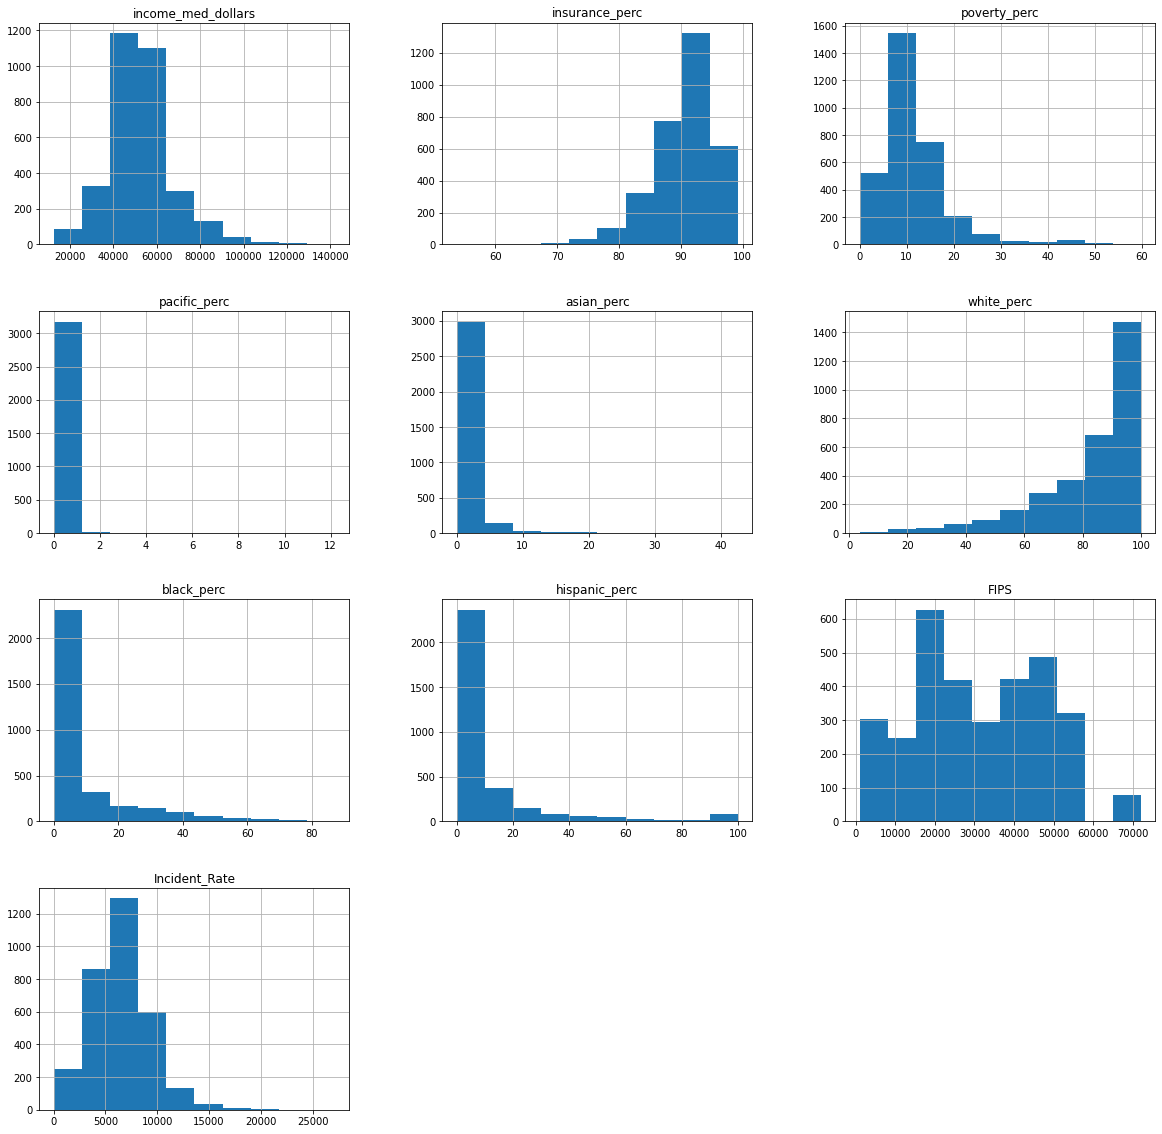

In [70]:
plotAllDistributions(prediction_raw)

In [71]:
pred_X = nan_prediction.drop(columns= "Incident_Rate")
pred_y = nan_prediction["Incident_Rate"]

In [72]:
train_X, test_X, train_y, test_y = train_test_split(pred_X, pred_y, test_size= 0.2, random_state= 79)

In [73]:
xgbst = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 10, seed = 123) 

In [74]:
xgbst.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

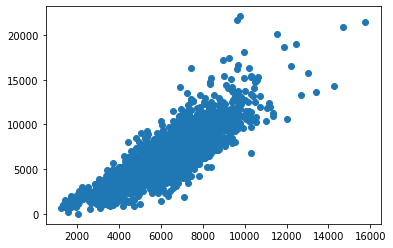

In [75]:
plt.scatter(xgbst.predict(train_X), train_y)

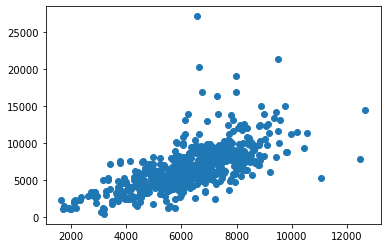

In [76]:
plt.scatter(xgbst.predict(test_X), test_y)

In [81]:
def xgboostRMSE(x, y):
    xval = xgbst.predict(x)
    rss = (xval - y)**2
    rmse = (np.mean(rss))**(1/2)
    return rmse

In [83]:
xgboostRMSE(train_X, train_y)

1612.4070338290003

In [84]:
xgboostRMSE(test_X, test_y)

2236.2602122652565

In [ ]:
## Our error is still quite high!
## We need to optimize our model through hyperparameter tuning and feature engineering.